In [50]:
import os
import pandas as pd

import yaml
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns



def get_hyperparm_df(main_dir):
    max_map50s = []
    max_recalls = []
    max_precisions = []
    momentums = []
    lr0s = []
    weight_decays = []
    training_dir = []
    steps = []

    step = 0
    all_trainings = os.listdir(main_dir)
    all_trainings.sort()

    best_score = 0
    best_model_dir = ""
    for train in all_trainings:
        dir_ = os.path.join(main_dir, train)
        all_files = os.listdir(dir_)

        if ("args.yaml" in all_files) and ("results.csv" in all_files):
            df = pd.read_csv(os.path.join(dir_, "results.csv"))
            conf = yaml.safe_load(Path(os.path.join(dir_ ,'args.yaml')).read_text())

            new_columns_names = [x.lstrip() for x in df.columns]
            df.columns = new_columns_names

            momentums.append(conf['momentum'])
            weight_decays.append(conf['weight_decay'])
            lr0s.append(conf['lr0'])
            
            t = df.loc[df['metrics/mAP50(B)'].idxmax()]

            max_map50s.append(t['metrics/mAP50(B)'].max())
            max_recalls.append(t['metrics/recall(B)'].max())
            max_precisions.append(t['metrics/precision(B)'].max())
            training_dir.append(dir_)
            step +=1
            steps.append(step)

            if df['metrics/mAP50(B)'].max() > best_score:
                best_score = df['metrics/mAP50(B)'].max()
                best_model_dir = dir_

    df_new = pd.DataFrame()
    df_new['max_map50s'] = max_map50s
    df_new['max_recalls'] = max_recalls
    df_new['max_precisions'] = max_precisions
    df_new['momentums'] = momentums
    df_new['lr0s'] = lr0s
    df_new['weight_decays'] = weight_decays
    df_new['training_dir'] = training_dir
    df_new['steps'] = steps

    return df_new, best_model_dir


main_dir = "runs/detect"
v8_df, best_model_dir_v8 = get_hyperparm_df('yolov8again/runs/detect')
v11_df, best_model_dir_v11 = get_hyperparm_df('yolov11/runs/detect')
df_scores = pd.read_csv(os.path.join(best_model_dir_v11, "results.csv"))
v8_df['model'] = 'YOLOv8'
v11_df['model'] = 'YOLOv11'

In [55]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: #c0dccd' if is_max.any() else '' for v in is_max]

def highlight_yolov8(s, val, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == val
    return ['background-color: #ffffb3' if is_max.any() else '' for v in is_max]

df_fig = pd.concat([v8_df,v11_df],ignore_index=True).sort_values(by="max_map50s", ascending=False)

used_cols = [col for col in df_fig.columns if col not in ['training_dir', 'steps']]
df_fig = df_fig[used_cols].reset_index(drop=True)
df_fig.max_map50s = df_fig.max_map50s.round(4)
df_fig.max_recalls = df_fig.max_recalls.round(3)
df_fig.max_precisions = df_fig.max_precisions.round(3)
df_fig.momentums = df_fig.momentums.round(3)
df_fig.lr0s = df_fig.lr0s.round(3)
df_fig.weight_decays = df_fig.weight_decays.round(6)
df_fig.weight_decays = df_fig.weight_decays.apply(lambda val: '%.2E' % val)

df_fig = df_fig.drop_duplicates().head(15).reset_index(drop=True)

import seaborn as sns
# cm = sns.light_palette("blue", as_cmap=True)
# cm = sns.palplot(sns.cubehelix_palette(start=2, rot=0, dark=0.4, light=.5))
cm = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=.7, as_cmap=True)

df_fig.columns = ["mAP50", "Recall", "Precision", "Momentum (hyperparam)", "Learning Rate (hyperparam)", "Weight Decay (hyperparam)", "Model"]
df_fig = df_fig[['Model', "Momentum (hyperparam)", "Learning Rate (hyperparam)", "Weight Decay (hyperparam)", "Recall", "Precision", "mAP50"]] 
df_fig = df_fig.style.format(precision=3, thousands=".").text_gradient(subset=['mAP50', 'Precision', "Recall"], cmap=cm)
df_fig = df_fig.apply(highlight_greaterthan, threshold=.465, column='mAP50', axis=1)
df_fig = df_fig.apply(highlight_yolov8, val="YOLOv8", column="Model", axis=1)
df_fig.set_table_styles([dict(selector="th",props=[('max-width', '90px')]),  {'selector': 'th.col_heading', 'props': 'text-align: center;'}])


# df.style.apply(highlight_greaterthan, threshold=1.0, column=['C', 'B'], axis=1)


,Model,Momentum (hyperparam),Learning Rate (hyperparam),Weight Decay (hyperparam),Recall,Precision,mAP50
0,YOLOv11,0.875,0.047,2.17E-04,0.438,0.573,0.466
1,YOLOv11,0.923,0.005,9.06E-04,0.463,0.510,0.460
2,YOLOv11,0.987,0.025,1.92E-04,0.470,0.544,0.460
3,YOLOv11,0.961,0.018,2.42E-04,0.494,0.461,0.458
4,YOLOv11,0.938,0.078,1.57E-04,0.435,0.564,0.458
5,YOLOv8,0.961,0.018,2.42E-04,0.411,0.568,0.452
6,YOLOv11,0.887,0.001,5.05E-04,0.514,0.486,0.450
7,YOLOv11,0.827,0.055,2.98E-04,0.444,0.580,0.449
8,YOLOv11,0.867,0.046,3.00E-04,0.483,0.508,0.445
9,YOLOv11,0.937,0.015,3.45E-04,0.410,0.544,0.445


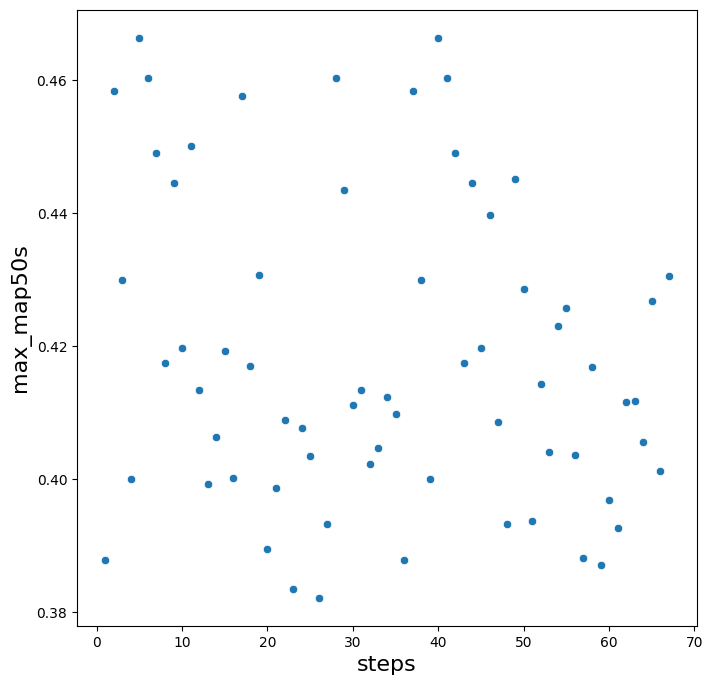

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.scatterplot(data=df_new, x="steps", y="max_map50s")
_=ax.set_xlabel('steps', fontsize=16)
_=ax.set_ylabel('max_map50s', fontsize=16) 
plt.show()

In [4]:
from ultralytics import YOLO

# Load a model
model = YOLO(os.path.join(best_model_dir, "weights", "best.pt"))  # pretrained YOLO11n model

# Run batched inference on a list of images

images = os.listdir("/home/sam/data/ladi/dataset_for_model2/val")
images = [x for x in images if x.endswith(".jpg")]
images = [os.path.join("/home/sam/data/ladi/dataset_for_model2/val", x) for x in images]
results = model(images)  # return a list of Results objects

# Process results list
# for result in results:
#     boxes = result.boxes  # Boxes object for bounding box outputs
#     masks = result.masks  # Masks object for segmentation masks outputs
#     keypoints = result.keypoints  # Keypoints object for pose outputs
#     probs = result.probs  # Probs object for classification outputs
#     obb = result.obb  # Oriented boxes object for OBB outputs
    # result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk

/home/sam/venvs/py39/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


0: 640x640 7 Major Damages, 58.1ms
1: 640x640 1 Major Damage, 58.1ms
2: 640x640 1 Affected Buildings, 58.1ms
3: 640x640 9 Major Damages, 58.1ms
4: 640x640 6 Major Damages, 58.1ms
5: 640x640 1 Major Damage, 58.1ms
6: 640x640 (no detections), 58.1ms
7: 640x640 5 Affected Buildingss, 8 Major Damages, 58.1ms
8: 640x640 1 Affected Buildings, 2 Major Damages, 58.1ms
9: 640x640 2 Affected Buildingss, 58.1ms
10: 640x640 4 Major Damages, 58.1ms
11: 640x640 2 Major Damages, 58.1ms
12: 640x640 6 Affected Buildingss, 30 Major Damages, 58.1ms
13: 640x640 1 Major Damage, 58.1ms
14: 640x640 11 Affected Buildingss, 1 Major Damage, 58.1ms
15: 640x640 20 Major Damages, 58.1ms
16: 640x640 2 Major Damages, 58.1ms
17: 640x640 5 Major Damages, 58.1ms
18: 640x640 7 Major Damages, 58.1ms
19: 640x640 11 Affected Buildingss, 2 Major Damages, 58.1ms
20: 640x640 8 Major Damages, 58.1ms
21: 640x640 5 Major Damages, 58.1ms
22: 640x640 1 Affected Buildings, 5 Major Damages, 58.1ms
23: 640x640 1 Affected Buildings, 5

In [30]:
detections = []
class_map = {0: 'Affected Buildings', 1: 'Major Damage'}

for result, img in zip(results, images):

    for box, cls, conf in zip(result.boxes.xywh.tolist(), result.boxes.cls.tolist(), result.boxes.conf.tolist()):

        detect = {
            "img": img,
            "xywh": box,
            "confidence": conf,
            "label": class_map[cls],
            "width": result.orig_shape[0], 
            "height": result.orig_shape[1]
        }

        detections.append(detect)

import json
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(detections, f, ensure_ascii=False, indent=4)


In [26]:
df = pd.read_csv("/home/sam/Downloads/loss_data_val.csv")
df.head()

,Wall time,Step,val_loss,train_loss
0,1.733198e+09,1,2.49105,1.51089
1,1.733198e+09,2,2.45573,1.42781
2,1.733198e+09,3,2.32619,1.39522
3,1.733198e+09,4,2.29529,1.42648
4,1.733198e+09,5,2.36229,1.30712


In [54]:
df.tail()

,Wall time,Step,val_loss,train_loss
57,1.733200e+09,58,2.00428,1.01310
58,1.733200e+09,59,2.01183,1.00004
59,1.733200e+09,60,2.04616,1.01373
60,1.733200e+09,61,1.96887,1.00497
61,1.733200e+09,62,1.95161,1.00949


In [ ]:
sns.lineplot(data=df_scores, x="epoch", y="metrics/mAP50(B)")
ax2 = plt.twinx()

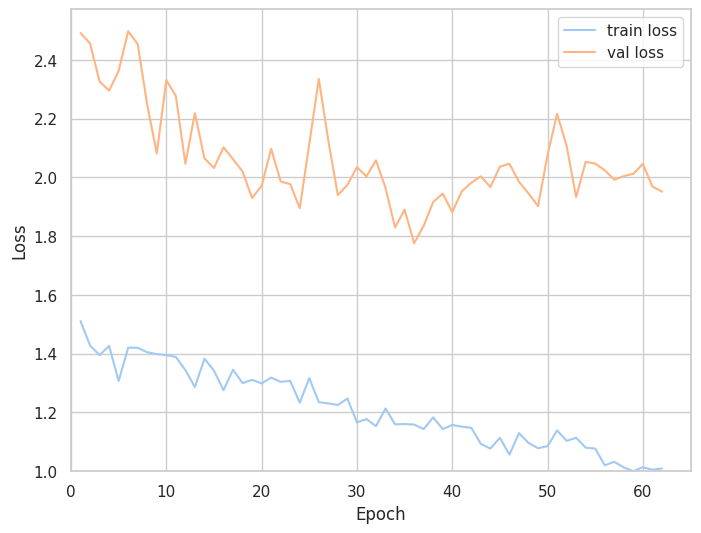

In [53]:

plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid", palette="pastel")
g = sns.lineplot(data=df, x="Step", y="train_loss", label="train loss")
sns.lineplot(data=df, x="Step", y="val_loss", label = 'val loss' )
g.set(xlabel="Epoch", ylabel="Loss")
plt.xlim(0)
plt.ylim(1)
plt.savefig("train_val_loss.png", bbox_inches='tight')